In [1]:
from numpy import mean ,std
import numpy as np
from sklearn.model_selection import cross_val_score , cross_validate ,RepeatedKFold ,GridSearchCV ,train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor ,RandomForestRegressor , GradientBoostingRegressor
from sklearn.metrics import r2_score ,mean_absolute_error
from sklearn.neural_network import MLPRegressor
from matplotlib import pyplot
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import pandas as pd
import csv
import matplotlib.pyplot as plt
import joblib
import lightgbm as lgb
from ipynb.fs.full.set_up import data_prep



In [2]:
models_list = {
    'CatBoostRegressor': CatBoostRegressor(logging_level='Silent'),
    'XGBRegressor': XGBRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor()
}

# Update best_params dictionary with additional model parameters
best_params = {
    'RandomForestRegressor': {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200},
    'CatBoostRegressor': {'depth': 10, 'iterations': 1500, 'l2_leaf_reg': 9, 'learning_rate': 0.05},
    'XGBRegressor': {'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 150},
    'LinearRegression': {'fit_intercept': True, 'positive': True},
    'GradientBoostingRegressor': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3},
    'LGBMRegressor': {'boosting_type': 'gbdt', 'num_leaves': 30, 'learning_rate': 0.1, 'n_estimators': 200}
}

# best_params = {
#     'RandomForestRegressor': {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100},
#     'CatBoostRegressor': {'depth': 3, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.05},
#     'XGBRegressor': {'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 50},
#     'LinearRegression': {'fit_intercept': True, 'positive': True},
#     'GradientBoostingRegressor': {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3},
#     'LGBMRegressor': {'boosting_type': 'gbdt', 'num_leaves': 30, 'learning_rate': 0.1, 'n_estimators': 50}
# }


params = {
    'CatBoostRegressor': {'iterations': [1000, 1200],'learning_rate': [0.01,0.05],'depth': [8,10],'l2_leaf_reg': [3,9]},
    'RandomForestRegressor': {'bootstrap': [True, False],'max_depth': [5, 10, 15],'max_features': ['auto', 'sqrt'],'min_samples_leaf': [1, 2, 4],'n_estimators': [100, 150, 200],'min_samples_split': [2, 5, 10]},
    'XGBRegressor': {'learning_rate': [0.07, 0.1, 0.15],'max_depth': [5, 7, 10],'n_estimators': [150, 200, 250],'max_leaves':[2,3,4]},
    'LinearRegression': {'fit_intercept': [True, False], 'positive': [True, False]},
    'GradientBoostingRegressor': {'n_estimators': [100,200,300], 'learning_rate': [0.1,0.2,0.3], 'max_depth': [3,5,7]},
    'LGBMRegressor': {'boosting_type': ['gbdt'], 'num_leaves': [10, 20, 30], 'learning_rate': [0.1, 0.2, 0.3], 'n_estimators': [100, 200, 300]}
}





Prep
(53383, 26)


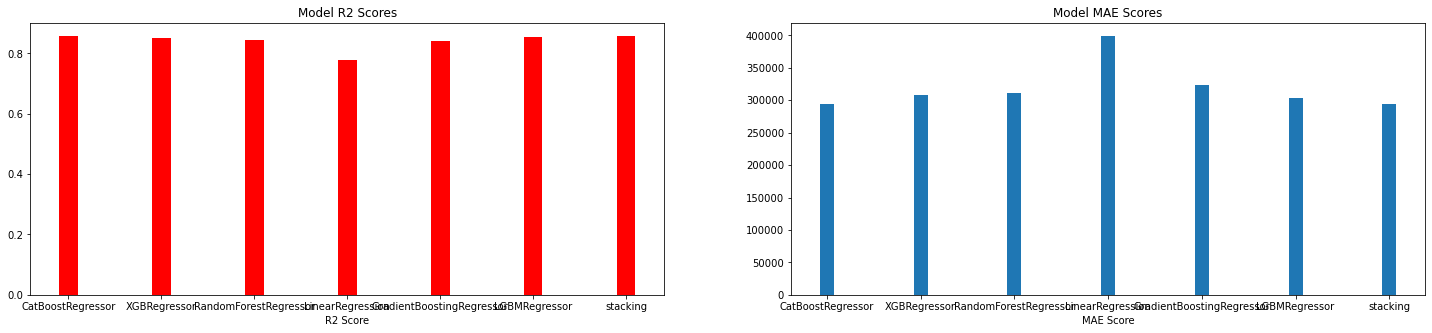

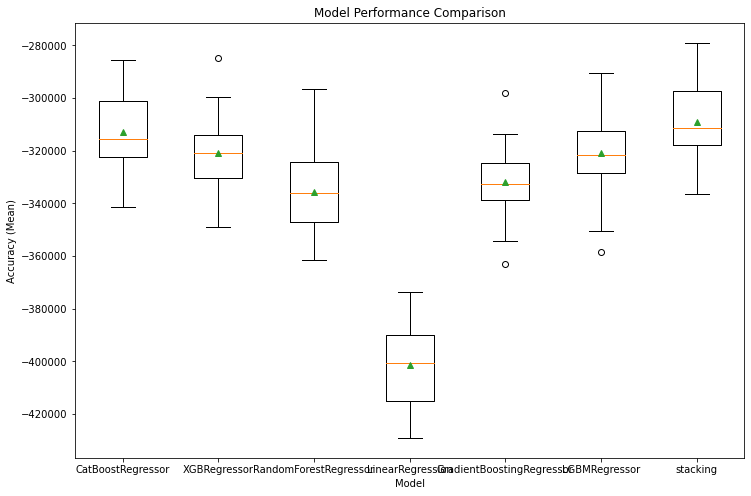

In [3]:
def get_models_with_best_params(best_params):
    models = dict()
    models['CatBoostRegressor'] = CatBoostRegressor(**best_params['CatBoostRegressor'], logging_level='Silent')
    models['XGBRegressor'] = XGBRegressor(**best_params['XGBRegressor'])
    models['RandomForestRegressor'] = RandomForestRegressor(**best_params['RandomForestRegressor'])
    models['LinearRegression'] = LinearRegression(**best_params['LinearRegression'])
    models['GradientBoostingRegressor'] = GradientBoostingRegressor(**best_params['GradientBoostingRegressor'])
    models['LGBMRegressor'] = lgb.LGBMRegressor(**best_params['LGBMRegressor'])

    models['stacking'] = get_stacking(best_params)
    return models


def get_stacking(params):
    level0 = []
    level0.append(('CatBoostRegressor', CatBoostRegressor(**params['CatBoostRegressor'], logging_level='Silent'))) 
    level0.append(('RandomForestRegressor', RandomForestRegressor(**params['RandomForestRegressor'])))
    level0.append(('XGBRegressor', XGBRegressor(**params['XGBRegressor'])))
    level0.append(('LinearRegression', LinearRegression(**params['LinearRegression'])))
    level0.append(('GradientBoostingRegressor', GradientBoostingRegressor(**params['GradientBoostingRegressor'])))
    level0.append(('LGBMRegressor', lgb.LGBMRegressor(**params['LGBMRegressor'])))

     # define meta-learner model
    level1 = LinearRegression(**params['LinearRegression'])

    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model
 
def find_best_params(models , X_train_selected ,y_train ):
    best_params = {}
    
    for name, model in models.items():
        print("Tuning", name)
        clf = GridSearchCV(model, params[name], cv=10, n_jobs=-1)
        clf.fit(X_train_selected, y_train)
        best_params[name] = clf.best_params_
        print("Best parameters:", best_params[name])
        
    return best_params
 
    
def evaluate_model(model,X_train_scaled, X_test_scaled  ,y_train, y_test):
    
    model_train = model.fit(X_train_scaled , y_train)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    results_score = cross_val_score(model_train, X_test_scaled, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1  )

    y_pred = model_train.predict(X_test_scaled)
        
    r2 = r2_score(y_test, y_pred)
    mae_score = mean_absolute_error(y_test, y_pred)

    return {
        'accuracy': {'mean': mean(results_score), 'std': std(results_score)},
        'r2_score': r2,
        'mae_score': mae_score,
        'results_score': results_score,
        'y_pred': y_pred,
        'model': model_train
    }


X_train_scaled,  X_test_scaled  ,y_train, y_test , X_train, X_test = data_prep(start_year = 2003 , min_price = 1200000 ,max_price =7000000 )

# best_params = find_best_params(models_list , X_train_scaled ,y_train )


models = get_models_with_best_params(best_params)


# evaluate the models and store results
scores = {}
saved_models = {}
for name, model in models.items():
    score = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    scores[name] = score
    saved_models[name] = model  # Save the model itself
    
joblib.dump(saved_models, 'saved_models.pkl')    

    
# plot model performance for comparison
def result_plot(scores):
    res_scores = []
    model_names = []

    for model_name, model_scores in scores.items():
        res_scores.append(scores[model_name]['results_score'])
        model_names.append(model_name)
    fig, ax = plt.subplots(figsize=(12,8))
    ax.boxplot(res_scores, labels=model_names, showmeans=True)
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy (Mean)')
    ax.set_title('Model Performance Comparison')
    plt.show()
    
    
def plot_model_scores(scores):
    r2_scores = []
    mae_scores = []
    model_names = []

    for model_name, model_scores in scores.items():
        r2_scores.append(model_scores['r2_score'])
        mae_scores.append(model_scores['mae_score'])
        model_names.append(model_name)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(25, 5))
    ax1.bar(model_names, r2_scores ,width=0.2 , color = 'Red')
    ax1.set_xlabel('R2 Score')
    ax1.set_title('Model R2 Scores')

    ax2.bar(model_names, mae_scores , width=0.15)
    ax2.set_xlabel('MAE Score')
    ax2.set_title('Model MAE Scores')

    plt.show()
    
plot_model_scores(scores)
result_plot(scores)


In [9]:
def predict_test_data(df, scores):
    y = df['Price']
    X = df.drop('Price', axis=1)
    
    scaler = joblib.load('scaler.pkl')
    X_scaled = scaler.transform(X)
    df_predict_dict = {}
    
    for model_name, model_scores in scores.items():
        y_pred = scores[model_name]['model'].predict(X_scaled)
        y_pred = y_pred *1.00
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        df_predict = pd.DataFrame({'Price': y, 'predicted price': y_pred , 'diff': y - y_pred })
        pos_count = len(df_predict[df_predict['diff'] > 0])
        neg_count = len(df_predict[df_predict['diff'] < 0])
        
        df_predict['diff'] = df_predict['diff'].astype(int)
        df_predict['predicted price'] = df_predict['predicted price'].astype(int)

        df_predict_dict[model_name] = df_predict
        print(f'{model_name}\nr2_score: {r2} , mae: {int(mae)}')
        print(f"pos_count:{pos_count} ,neg_count:{neg_count}\n")
    return df_predict_dict

yad2_df , item_id = data_prep(valid = True , accuracy = 0 ,min_price = 1200000 ,max_price =6000000) #, accuracy = 100


yad_2_results = predict_test_data(yad2_df,scores)

# yad_2_results['stacking']


Prep
(460, 32)
CatBoostRegressor
r2_score: 0.6678487551763881 , mae: 479626
pos_count:227 ,neg_count:131

XGBRegressor
r2_score: 0.6626499269634916 , mae: 489834
pos_count:234 ,neg_count:124

RandomForestRegressor
r2_score: 0.6682147934514997 , mae: 476424
pos_count:258 ,neg_count:100

LinearRegression
r2_score: 0.39073597562289364 , mae: 672915
pos_count:164 ,neg_count:194

GradientBoostingRegressor
r2_score: 0.6651876867919022 , mae: 490325
pos_count:232 ,neg_count:126

LGBMRegressor
r2_score: 0.6673704315221713 , mae: 478382
pos_count:225 ,neg_count:133

stacking
r2_score: 0.6908153864935971 , mae: 465225
pos_count:216 ,neg_count:142



In [10]:
def recommend_affordable_apartments(df, model ,item_id):
    y = df['Price']
    X = df.drop('Price', axis=1)

    scaler = joblib.load('scaler.pkl')
    X_scaled = scaler.transform(X)
    
    y_pred = model.predict(X_scaled)
    y_pred = y_pred *1.00
    df["Predicted"] = y_pred
    df["Predicted"] = df["Predicted"].astype(int)
    df['Difference'] =  df["Price"] -  df["Predicted"] 
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f'r2_score: {r2} , mae: {mae}')
    df['Item_id'] = item_id
    df["Predicted"] = df["Predicted"].astype(np.int32)
    df["Difference"] = df["Difference"].astype(np.int32)

    return df.sort_values(by="Difference")

yad2_df , item_id = data_prep(valid = True , accuracy = 0 ,min_price = 1200000 ,max_price =6000000) #, accuracy = 100

m = joblib.load('saved_models.pkl')

model = m['stacking']

yad_2_results = recommend_affordable_apartments(yad2_df,model, item_id)
yad_2_results

Prep
(460, 32)
r2_score: 0.6908153864935971 , mae: 465225.33041283424


,Rooms,Floor,Size,Price,Build_year,Floors,Long,Lat,Year,Distance_sea,Train,Age,Neighborhood_rank,Street_rank,Gush_rank,Helka_rank,Predicted,Difference,Item_id
337,2,0,85,3990000,1940,3,178443,664903,2023,453,2609,83,60846,78906,55181,77889,5463308,-1473308,ywu24biw
328,4,1,120,4400000,1950,4,178573,664782,2023,615,2358,73,60846,58570,53825,56048,5801766,-1401766,lqqbsyqu
671,4,1,95,4900000,1981,5,178612,664504,2023,740,2041,42,60846,68865,69397,69159,6225601,-1325601,gds1wxv6
946,3,1,80,2650000,1953,2,182122,662646,2023,4658,2522,70,48000,56666,48000,42728,3687710,-1037710,st5m5wsh
548,3,1,83,4700000,1951,3,32,34,2023,42305,842179,72,69705,77000,68200,69489,5733800,-1033800,me049af0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,4,4,83,5950000,1946,5,179320,666369,2023,819,2461,77,59259,48265,60470,45844,4174842,1775158,r23vhdwo
585,3,1,60,4650000,1999,5,179131,664265,2023,1308,1692,24,58990,55437,31750,56998,2831114,1818886,sw1i7xno
616,3,1,87,5150000,1970,7,179698,666266,2023,1211,1980,53,66047,65324,33841,33103,3230346,1919654,6xl0c5z5
432,4,3,93,5200000,2006,6,177533,662640,2023,309,2502,17,45371,46470,65528,12654,3240313,1959687,x7tuqws4


In [8]:
df = pd.read_csv("../Data/yad_2_data.csv")


merged_df = pd.concat([df.set_index('Item_id'), yad2_df.set_index('Item_id')], axis=1, join='inner')
merged_df = merged_df.reset_index()
merged_df.index += 1
merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]
merged_df = merged_df.drop_duplicates(subset='Item_id')

cols = ['Text']
merged_df.to_csv('../Data/Predicted_DB.csv') 

# merged_df.drop(columns = cols, inplace = True)
merged_df = merged_df.sort_values(by="Difference")
# merged_df
